# Data Analysis for Business, Economics, and Policy
---
## Asssignment 2
Ambrus Fodor, Katharina Burtscher


In [37]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [38]:
# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)


# Import data

In [39]:

#data = pd.read_csv("https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%202/cs_bisnode_panel.csv")


In [40]:
data = pd.read_csv("cs_bisnode_panel.csv")

In [41]:
# Get the sets of unique company IDs for each year
ids_2012 = set(data.loc[data["year"] == 2012, "comp_id"])
ids_2013 = set(data.loc[data["year"] == 2013, "comp_id"])

# Find the intersection (companies present in both years)
common_ids = ids_2012.intersection(ids_2013)

data = data[data["comp_id"].isin(common_ids)]

In [42]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224766 entries, 0 to 287828
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               224766 non-null  float64
 1   begin                 224766 non-null  object 
 2   end                   224766 non-null  object 
 3   amort                 219828 non-null  float64
 4   curr_assets           224695 non-null  float64
 5   curr_liab             224695 non-null  float64
 6   extra_exp             210900 non-null  float64
 7   extra_inc             210900 non-null  float64
 8   extra_profit_loss     211294 non-null  float64
 9   fixed_assets          224695 non-null  float64
 10  inc_bef_tax           220313 non-null  float64
 11  intang_assets         224687 non-null  float64
 12  inventories           224695 non-null  float64
 13  liq_assets            224695 non-null  float64
 14  material_exp          219828 non-null  float64
 15  perso

In [44]:
data.head()

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333



# Label engineering


In [45]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [46]:
data = data.sort_values(['comp_id', 'year'])

# We group by comp_id to ensure we don't accidentally pull sales from a different firm
data['sales_growth'] = data.groupby('comp_id')['sales'].pct_change(periods=1)

#drop nan in sales_growth
data = data.dropna(subset="sales_growth")

In [47]:
data["sales"].isna().sum()

np.int64(17107)

##### Defining "fast growth"
- Potential outcome variables:
    - curr_assets "Current assets"
    - fixed_assets "fixed assets"
    - inc_bef_tax "income before tax"
    - profit_loss_year "profit/loss, annual"
    - sales "total sales"

- In the end we decided to go with *sales* beacuse:
    - *profit_loss_year* can not capture the growth of rapidly expanding companies, which keep their profits low to buy new equipment/hire new people
    - the change in assests discriminate against certain industires like tech/service sector, which don't have expensive assets
    - *inc_bef_tax* in finance income already has expenses deducted, so the problem is the same as with *profit_loss_year*
    - *sales* is a straight forward measure: every company is selling something be that a product or a service. Even start-ups which are backed by venture capital funds have usually fast growing sales eventough they are loosing money (think about the AI boom)
- The functional form
    - We have decided to take the percentage growth in sales between 2012 and 2013 by taking simply the percentage difference between the values for the dates. We choose to take values from 2012 and 2013, because more data was available for those.
    - We also have to decide on a cut-off: From which growth rate can we call a company fast growing?




In [48]:
data["sales"].describe()


count    1.765100e+05
mean     6.255274e+05
std      3.947257e+06
min     -9.232593e+04
25%      1.601481e+04
50%      5.455926e+04
75%      1.779176e+05
max      1.099510e+08
Name: sales, dtype: float64

In [49]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [50]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [51]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [52]:
data["new"].describe()


count    193617.000000
mean          0.315587
std           0.464750
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

# Sample design

In [53]:
#drop firms which had missing sales for 2012
missing_in_12 = data.loc[(data["year"] == 2012) & (data["sales"].isnull()), "comp_id"]
data = data[~data["comp_id"].isin(missing_in_12)]
# look at firms below 10m euro revenues and above 10000
outside_treshold_in_12 = data.loc[(data["year"] == 2012) & ((data["sales_mil"] >= 10) | (data["sales_mil"] <= 0.01)), "comp_id"] 
data = data[~data["comp_id"].isin(outside_treshold_in_12)]
#keep data for year of interest, and where sales_growth is not infinite
data = data[(data["year"] == 2013) & (np.abs(data["sales_growth"]) != np.inf)]

In [54]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,founded_date,exit_date,labor_avg,sales_growth,ln_sales,sales_mil,sales_mil_log,d1_sales_mil_log,age,new
206970,2013,1.002029e+06,2013-01-01,2013-12-31,14255.555664,2.171037e+05,1.611741e+05,0.0,0.0,0.0,...,2006-07-03,NaN,0.437500,-0.684947,12.788464,0.358063,-1.027046,-1.155013,7.0,0.0
206971,2013,1.011889e+06,2013-01-01,2013-12-31,66125.929688,2.351148e+05,1.655555e+04,0.0,0.0,0.0,...,1992-11-09,NaN,1.583333,0.019293,12.999141,0.442033,-0.816370,0.019109,21.0,0.0
206972,2013,1.014183e+06,2013-01-01,2013-12-31,6970.370605,2.095630e+05,5.703704e+03,0.0,0.0,0.0,...,2001-12-21,NaN,0.819444,-0.104205,11.663164,0.116211,-2.152347,-0.110044,12.0,0.0
206974,2013,1.022796e+06,2013-01-01,2013-12-31,503.703705,3.859259e+03,8.114815e+03,0.0,0.0,0.0,...,2001-02-01,2016-06-06,0.083333,0.629293,10.657695,0.042519,-3.157816,0.488146,12.0,0.0
206975,2013,1.035705e+06,2013-01-01,2013-12-31,244.444443,2.392593e+03,9.733333e+03,0.0,0.0,0.0,...,2011-10-26,NaN,0.222222,-0.076306,10.007514,0.022193,-3.807997,-0.079375,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232833,2013,4.638854e+11,2013-01-01,2013-12-31,4977.777832,6.201111e+04,3.924074e+04,0.0,0.0,0.0,...,2009-02-25,NaN,0.083333,1.365346,12.819485,0.369344,-0.996026,0.860924,4.0,0.0
232834,2013,4.639820e+11,2013-01-01,2013-12-31,12003.704102,1.091148e+05,1.506185e+05,0.0,0.0,0.0,...,1995-05-14,NaN,0.506944,0.939912,12.821779,0.370193,-0.993732,0.662642,18.0,0.0
232835,2013,4.640212e+11,2013-01-01,2013-12-31,2603.703613,4.088148e+04,3.361111e+04,0.0,0.0,0.0,...,2006-05-09,NaN,0.083333,0.532853,10.973738,0.058322,-2.841772,0.000000,NaN,1.0
232836,2013,4.640446e+11,2013-01-01,2013-12-31,77248.148438,6.055000e+06,1.930922e+06,0.0,0.0,0.0,...,2008-10-09,NaN,1.993056,0.012234,15.971726,8.638381,2.156215,0.012160,5.0,0.0


In [ ]:
data = data[data["sales_growth"] < 10]

In [60]:
data.sort_values(by="sales_growth")

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,founded_date,exit_date,labor_avg,sales_growth,ln_sales,sales_mil,sales_mil_log,d1_sales_mil_log,age,new
219284,2013,1.040925e+11,2013-01-01,2013-12-31,-407.407410,751.851868,8348.148438,0.0,0.000000,0.000000,...,2008-06-09,2015-09-19,0.312500,-2.087052,0.000000,0.000001,-13.815511,-10.930657,5.0,0.0
208844,2013,2.443873e+09,2013-01-01,2013-12-31,0.000000,7581.481445,17362.962891,0.0,0.000000,0.000000,...,2010-09-16,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,2.558242,3.0,0.0
217254,2013,7.241617e+10,2013-01-01,2013-12-31,0.000000,10066.666992,18055.554688,0.0,0.000000,0.000000,...,2008-04-23,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,3.924508,5.0,0.0
214804,2013,4.241476e+10,2013-01-01,2013-12-31,777.777771,25.925926,570.370361,0.0,0.000000,0.000000,...,2000-11-15,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,4.378773,13.0,0.0
227078,2013,2.780410e+11,2013-01-01,2013-12-31,5907.407227,0.000000,61029.628906,0.0,0.000000,0.000000,...,1995-03-01,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209768,2013,5.399597e+09,2013-01-01,2013-12-31,4777.777832,11144.444336,44648.148438,0.0,0.000000,0.000000,...,2012-07-16,NaN,0.888889,6.530884,13.073072,0.475952,-0.742439,0.000000,NaN,1.0
218302,2013,8.840449e+10,2013-01-01,2013-12-31,3285.185303,13725.925781,3548.148193,0.0,0.000000,0.000000,...,2012-09-07,NaN,NaN,6.536777,10.814058,0.049715,-3.001452,0.000000,1.0,1.0
227911,2013,3.017464e+11,2013-01-01,2013-12-31,0.000000,308807.406250,261262.968750,0.0,0.000000,0.000000,...,2011-11-29,NaN,NaN,6.566491,14.004434,1.207948,0.188923,2.023729,2.0,0.0
224238,2013,2.040023e+11,2013-01-01,2013-12-31,0.000000,2800.000000,0.000000,0.0,0.000000,0.000000,...,2012-10-24,NaN,NaN,6.567839,11.570985,0.105978,-2.244526,0.000000,1.0,1.0


(array([1.0000e+00, 3.0500e+03, 1.1455e+04, 1.5660e+03, 4.1000e+02,
        1.7700e+02, 1.2200e+02, 7.6000e+01, 5.8000e+01, 4.9000e+01]),
 array([-2.08705161, -1.21824778, -0.34944395,  0.51935988,  1.38816372,
         2.25696755,  3.12577138,  3.99457521,  4.86337904,  5.73218287,
         6.6009867 ]),
 <BarContainer object of 10 artists>)

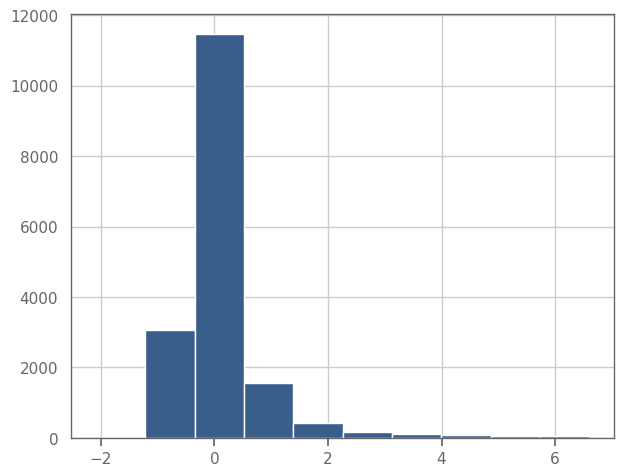

In [61]:
plt.hist(data["sales_growth"])

# Feature engineering

In [ ]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [ ]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0      43
26.0     900
27.0     560
28.0    1712
29.0     250
30.0     137
32.0     114
33.0    1647
40.0     179
55.0    1696
56.0    9889
60.0     179
99.0       4
Name: comp_id, dtype: int64

In [ ]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [ ]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    17297
1.0       12
Name: comp_id, dtype: int64

In [ ]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [ ]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    1.730900e+04
mean     3.352901e+05
std      2.028849e+06
min      0.000000e+00
25%      9.462963e+03
50%      3.372963e+04
75%      1.340444e+05
max      1.594840e+08
Name: total_assets_bs, dtype: float64

In [ ]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [ ]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [ ]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [ ]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [ ]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [ ]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [ ]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [ ]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [ ]:
data["labor_avg"].describe()


count    14532.000000
mean         0.730143
std          1.766210
min          0.083333
25%          0.138889
50%          0.263889
75%          0.611111
max         40.916668
Name: labor_avg, dtype: float64

In [ ]:
data["labor_avg_mod"].describe()


count    17310.000000
mean         0.730143
std          1.618281
min          0.083333
25%          0.166667
50%          0.356061
75%          0.730143
max         40.916668
Name: labor_avg_mod, dtype: float64

In [ ]:
data = data.drop(["labor_avg"], axis=1)


In [ ]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")


In [ ]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


In [ ]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()


count    17310.000000
mean         0.003922
std          0.878289
min        -10.930657
25%         -0.143040
50%          0.000000
75%          0.166523
max          5.261037
Name: d1_sales_mil_log, dtype: float64

In [ ]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [ ]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [ ]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    15462.000000
mean         9.576640
std          7.030083
min          0.000000
25%          3.000000
50%          8.000000
75%         16.000000
max         62.000000
Name: age, dtype: float64

In [ ]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


Text(0.5, 0, 'Growth rate (Diff of ln sales)')

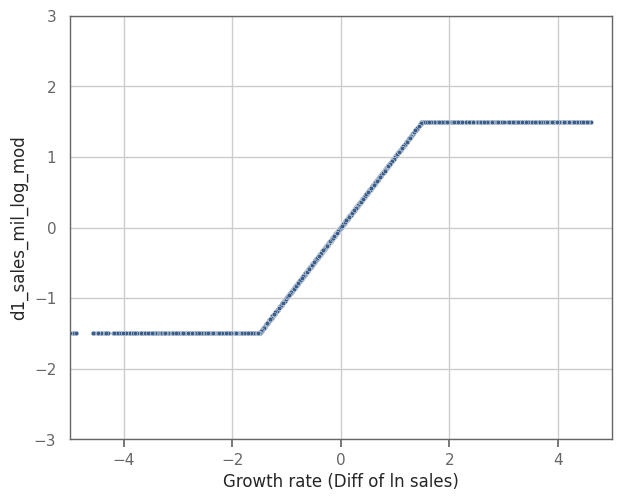

In [ ]:
sns.scatterplot(x="d1_sales_mil_log", y="d1_sales_mil_log_mod", s=10, data=data)
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.xlabel("Growth rate (Diff of ln sales)")

In [ ]:
data.to_csv("bisnode_firms_clean.csv", index=False)
